## RWKV TMix block python / triton validation

A much more aggressive, input / output delta comparision for timemix input / output between the various kernel implementation

In [1]:
# Configure the parent path to be the proj folder
import sys, os, torch, time
sys.path.append('../../')

# Import the block classes
from rwkv_block.v7_goose.block.rwkv7_time_mix import RWKV7TimeMix

# File to load
MODEL_FILENAME="v7-1B4.pth"

# Run device, and run dtype to use
RUN_DEVICE="cpu"
RUN_DTYPE=torch.bfloat16

# Check for cuda device
if torch.cuda.is_available():
    RUN_DEVICE="cuda:0"

# Check if the reference weights exists
assert os.path.exists(f"./.model/{MODEL_FILENAME}"), "The reference weights does not exist. Please download it first (00-model-download.ipynb)"

# Loads the model weights
model_weight = torch.load(f"./.model/{MODEL_FILENAME}", map_location='cpu', weights_only=True, mmap=True)

# Model filename
print(f"### Model filename: {MODEL_FILENAME}")

# Lets get the n_dim, and setup the test module
n_dim = model_weight['emb.weight'].shape[1]
print(f"### Model n_dim: {n_dim}")

# # List the model weights keys, and their shapes
# print(f"### model weights keys:")
# for key in model_weight:
#     print(f"{key}: {model_weight[key].shape} - {model_weight[key].dtype}")

# Ensure cuda path is set, get the cuda nvcc path
os.environ['CUDA_HOME'] = "/usr/local/cuda"

### Model filename: v7-1B4.pth
### Model n_dim: 2048


In [2]:
# Initialize the channelmix state, and x state to test
# NOTE: The triton kernel minimum chunk size is 16, it fallsback to pytorch mode otherwise
# we intentionally DO not use a unit of 16, so the remainder pytorch code kicks in for triton
IN_TOKENS_LEN=9000 
x_state_0 = torch.ones(1, IN_TOKENS_LEN, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE)
x_state_1 = torch.ones(1, IN_TOKENS_LEN, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE)
x_state_2 = torch.ones(1, IN_TOKENS_LEN, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE)
tmix_shift_0 = torch.ones(1, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE)
tmix_shift_1 = torch.ones(1, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE)
tmix_wkv_0 = torch.ones(1, n_dim // 64, 64, 64, device=RUN_DEVICE, dtype=torch.float)
tmix_wkv_1 = torch.ones(1, n_dim // 64, 64, 64, device=RUN_DEVICE, dtype=torch.float)

# Iteration to test
TEST_STEPS = 10

# Build the tmix blocks
tmix_pytorch = RWKV7TimeMix({ "n_layer":24, "n_dim":n_dim, "layer_id":0, "device":RUN_DEVICE, "dtype":RUN_DTYPE, "tmix_backend":"pytorch_ref" })
tmix_pytorch.load_from_model_state_dict(model_weight, 0)

# Slower reference implementation
tmix_pytorch_2 = RWKV7TimeMix({ "n_layer":24, "n_dim":n_dim, "layer_id":0, "device":RUN_DEVICE, "dtype":RUN_DTYPE, "tmix_backend":"pytorch" })
tmix_pytorch_2.load_from_model_state_dict(model_weight, 0)

tmix_triton = RWKV7TimeMix({ "n_layer":24, "n_dim":n_dim, "layer_id":0, "device":RUN_DEVICE, "dtype":RUN_DTYPE, "tmix_backend":"triton" })
tmix_triton.load_from_model_state_dict(model_weight, 0)

tmix_cuda = RWKV7TimeMix({ "n_layer":24, "n_dim":n_dim, "layer_id":0, "device":RUN_DEVICE, "dtype":RUN_DTYPE, "tmix_backend":"cuda" })
tmix_cuda.load_from_model_state_dict(model_weight, 0)

print(f"### Testing the tmix blocks for {TEST_STEPS} steps")

### Testing the tmix blocks for 10 steps


In [3]:
### TMix
with torch.inference_mode():

    # This is a warmup
    t0 = time.time()
    out_x = x_state_0
    t_shift = tmix_shift_0
    t_wkv = tmix_wkv_0
    v_first = x_state_2
    for i in range(TEST_STEPS):
        out_x, t_shift, t_wkv, v_first = tmix_pytorch_2.forward_with_reduce_compile(x_state_1, t_shift, tmix_wkv_1, v_first)
    t2 = time.time()
    print(f'1 tmix_pytorch_2 reduce-compile forward passes (warmup): {(t2-t0)*1000/TEST_STEPS} ms ({RUN_DEVICE}, {RUN_DTYPE})')

    # The actual run
    t1 = time.time()
    out_x = x_state_0
    t_shift = tmix_shift_0
    t_wkv = tmix_wkv_0
    v_first = x_state_2
    for i in range(TEST_STEPS):
        out_x, t_shift, t_wkv, v_first = tmix_pytorch_2.forward_with_reduce_compile(x_state_1, t_shift, tmix_wkv_1, v_first)
    t2 = time.time()
    print(f'1 tmix_pytorch_2 reduce-compile forward passes (normal): {(t2-t1)*1000/TEST_STEPS} ms ({RUN_DEVICE}, {RUN_DTYPE})')

skipping cudagraphs due to mutated inputs (1 instances). Found from : 
   File "/home/recursal/rwkv-prj/RWKV-block/test/v7_goose/../../rwkv_block/v7_goose/block/kernel/rwkv7_attn_pytorch.py", line 163, in torch_dynamo_resume_in_rwkv7_attn_pytorch_v2_chunk_w_compile_break_at_154
    xx[:] = (wkv_xx.to(dtype=xx.dtype) @ r.view(BATCH_SIZE,SEQ_LEN,N_HEAD,HEAD_SIZE,1)).view(BATCH_SIZE,SEQ_LEN,N_HEAD*HEAD_SIZE)

skipping cudagraphs due to mutated inputs (1 instances). Found from : 
   File "/home/recursal/rwkv-prj/RWKV-block/test/v7_goose/../../rwkv_block/v7_goose/block/kernel/rwkv7_attn_pytorch.py", line 163, in torch_dynamo_resume_in_rwkv7_attn_pytorch_v2_chunk_w_compile_break_at_154
    xx[:] = (wkv_xx.to(dtype=xx.dtype) @ r.view(BATCH_SIZE,SEQ_LEN,N_HEAD,HEAD_SIZE,1)).view(BATCH_SIZE,SEQ_LEN,N_HEAD*HEAD_SIZE)



1 tmix_pytorch_2 reduce-compile forward passes (warmup): 1542.76123046875 ms (cuda:0, torch.bfloat16)
1 tmix_pytorch_2 reduce-compile forward passes (normal): 662.9954099655151 ms (cuda:0, torch.bfloat16)


In [4]:
### TMix
with torch.inference_mode():

    # This is a warmup
    t0 = time.time()
    out_x = x_state_0
    t_shift = tmix_shift_0
    t_wkv = tmix_wkv_0
    v_first = x_state_2
    for i in range(TEST_STEPS):
        out_x, t_shift, t_wkv, v_first = tmix_triton.forward_with_reduce_compile(x_state_1, t_shift, tmix_wkv_1, v_first)
    t2 = time.time()
    print(f'1 tmix_triton reduce-compile forward passes (warmup): {(t2-t0)*1000/TEST_STEPS} ms ({RUN_DEVICE}, {RUN_DTYPE})')

    # The actual run
    t1 = time.time()
    out_x = x_state_0
    t_shift = tmix_shift_0
    t_wkv = tmix_wkv_0
    v_first = x_state_2
    for i in range(TEST_STEPS):
        out_x, t_shift, t_wkv, v_first = tmix_triton.forward_with_reduce_compile(x_state_1, t_shift, tmix_wkv_1, v_first)
    t2 = time.time()
    print(f'1 tmix_triton reduce-compile forward passes (normal): {(t2-t1)*1000/TEST_STEPS} ms ({RUN_DEVICE}, {RUN_DTYPE})')

1 tmix_triton reduce-compile forward passes (warmup): 472.18689918518066 ms (cuda:0, torch.bfloat16)
1 tmix_triton reduce-compile forward passes (normal): 22.803544998168945 ms (cuda:0, torch.bfloat16)


In [5]:
### TMix
with torch.inference_mode():

    # This is a warmup
    t0 = time.time()
    out_x = x_state_0
    t_shift = tmix_shift_0
    t_wkv = tmix_wkv_0
    v_first = x_state_2
    for i in range(TEST_STEPS):
        out_x, t_shift, t_wkv, v_first = tmix_cuda.forward_with_reduce_compile(x_state_1, t_shift, tmix_wkv_1, v_first)
    t2 = time.time()
    print(f'1 tmix_cuda reduce-compile forward passes (warmup): {(t2-t0)*1000/TEST_STEPS} ms ({RUN_DEVICE}, {RUN_DTYPE})')

    # The actual run
    t1 = time.time()
    out_x = x_state_0
    t_shift = tmix_shift_0
    t_wkv = tmix_wkv_0
    v_first = x_state_2
    for i in range(TEST_STEPS):
        out_x, t_shift, t_wkv, v_first = tmix_cuda.forward_with_reduce_compile(x_state_1, t_shift, tmix_wkv_1, v_first)
    t2 = time.time()
    print(f'1 tmix_cuda reduce-compile forward passes (normal): {(t2-t1)*1000/TEST_STEPS} ms ({RUN_DEVICE}, {RUN_DTYPE})')

Using /home/recursal/.cache/torch_extensions/py312_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/recursal/.cache/torch_extensions/py312_cu121/wind_backstepping/build.ninja...
/home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module wind_backstepping...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] c++ -MMD -MF wkv7_op.o.d -DTORCH_EXTENSION_NAME=wind_backstepping -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/include -isystem /home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/include/TH -isystem /home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/recursal/miniconda3/envs/py-3-12/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /home/recursal/rwkv-prj/RWKV-block/rwkv_block/v7_goose/block/kernel/cuda/wkv7_op.cpp -o wkv7_op.o 
[2/2] c++ wkv7_cuda.cuda.o wkv7_op.o -shared -L/home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/lib -lc10 -lc10_cuda -ltorch_cp

Loading extension module wind_backstepping...
/home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/cuda/graphs.py:84: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647406761/work/aten/src/ATen/cuda/CUDAGraph.cpp:208.)
  super().capture_end()
/home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/cuda/graphs.py:84: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647406761/work/aten/src/ATen/cuda/CUDAGraph.cpp:208.)
  super().capture_end()
/home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/cuda/graphs.py:84: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internal

1 tmix_cuda reduce-compile forward passes (warmup): 2127.5617599487305 ms (cuda:0, torch.bfloat16)


/home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/cuda/graphs.py:84: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647406761/work/aten/src/ATen/cuda/CUDAGraph.cpp:208.)
  super().capture_end()
/home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/cuda/graphs.py:84: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647406761/work/aten/src/ATen/cuda/CUDAGraph.cpp:208.)
  super().capture_end()
/home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/cuda/graphs.py:84: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /opt/conda/conda-bld/pytorch_17296474067

1 tmix_cuda reduce-compile forward passes (normal): 103.14416885375977 ms (cuda:0, torch.bfloat16)


In [6]:
### TMix
with torch.inference_mode():

    # Get output with python
    py_out_x, py_t_shift, py_t_wkv, py_v_first = tmix_pytorch.forward(
        torch.ones(1, IN_TOKENS_LEN, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE),
        torch.ones(1, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE), 
        torch.ones(1, n_dim // 64, 64, 64, device=RUN_DEVICE, dtype=torch.float), 
        torch.ones(1, IN_TOKENS_LEN, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE)
    )

    # Get output with python (again) : this catches initialisation issues
    py2_out_x, py2_t_shift, py2_t_wkv, py2_v_first = tmix_pytorch_2.forward(
        torch.ones(1, IN_TOKENS_LEN, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE),
        torch.ones(1, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE), 
        torch.ones(1, n_dim // 64, 64, 64, device=RUN_DEVICE, dtype=torch.float), 
        torch.ones(1, IN_TOKENS_LEN, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE)
    )

    # Get output with triton
    tr_out_x, tr_t_shift, tr_t_wkv, tr_v_first = tmix_triton.forward(
        torch.ones(1, IN_TOKENS_LEN, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE),
        torch.ones(1, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE), 
        torch.ones(1, n_dim // 64, 64, 64, device=RUN_DEVICE, dtype=torch.float), 
        torch.ones(1, IN_TOKENS_LEN, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE)
    )

    # Get output with triton
    cu_out_x, cu_t_shift, cu_t_wkv, cu_v_first = tmix_cuda.forward(
        torch.ones(1, IN_TOKENS_LEN, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE),
        torch.ones(1, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE), 
        torch.ones(1, n_dim // 64, 64, 64, device=RUN_DEVICE, dtype=torch.float), 
        torch.ones(1, IN_TOKENS_LEN, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE)
    )

    # Get the shape, and value range for each py_out_*
    print("Forward py_out_x   (shape:", py_out_x.shape, "min:", py_out_x.min().item(), "max:", py_out_x.max().item(), ")")
    print("Forward py_t_wkv   (shape:", py_t_wkv.shape, "min:", py_t_wkv.min().item(), "max:", py_t_wkv.max().item(), ")")
    print("Forward py_t_shift (shape:", py_t_shift.shape, "min:", py_t_shift.min().item(), "max:", py_t_shift.max().item(), ")")
    print("Forward py_v_first (shape:", py_v_first.shape, "min:", py_v_first.min().item(), "max:", py_v_first.max().item(), ")")

    # Splitter
    print("---")

    # Compute the delta between the two outputs (pytorch to pytorch)
    py_py_out_x = py_out_x - py2_out_x
    py_py_t_shift = py_t_shift - py2_t_shift
    py_py_t_wkv = py_t_wkv - py2_t_wkv
    py_py_v_first = py_v_first - py2_v_first

    # Reshape for display
    delta_py_py_out_x = py_py_out_x[-1][-1].view(n_dim // 64, -1).float().cpu().numpy()
    delta_py_py_t_wkv = py_py_t_wkv.view(n_dim // 64 * 8, -1).float().cpu().numpy()
    delta_py_py_t_shift = py_py_t_shift.view(n_dim // 64, -1).float().cpu().numpy()
    delta_py_py_v_first = py_py_v_first[-1][-1].view(n_dim // 64, -1).float().cpu().numpy()

    # Compute the max delta
    abs_max_delta_py_py_out_x = max(delta_py_py_out_x.min().item(), delta_py_py_out_x.max().item())
    abs_max_delta_py_py_t_wkv = max(delta_py_py_t_wkv.min().item(), delta_py_py_t_wkv.max().item())
    abs_max_delta_py_py_t_shift = max(delta_py_py_t_shift.min().item(), delta_py_py_t_shift.max().item())
    abs_max_delta_py_py_v_first = max(delta_py_py_v_first.min().item(), delta_py_py_v_first.max().item())

    # Compute and print the max/min delta
    print("Max delta (pytorch -> pytorch_v2) for x       (shape:", delta_py_py_out_x.shape," max:", delta_py_py_out_x.max().item(),", min:", delta_py_py_out_x.min().item(),")")
    print("Max delta (pytorch -> pytorch_v2) for t_wkv   (shape:", delta_py_py_t_wkv.shape," max:", delta_py_py_t_wkv.max().item(),", min:", delta_py_py_t_wkv.min().item(),")")
    print("Max delta (pytorch -> pytorch_v2) for t_shift (shape:", delta_py_py_t_shift.shape," max:", delta_py_py_t_shift.max().item(),", min:", delta_py_py_t_shift.min().item(),")")
    print("Max delta (pytorch -> pytorch_v2) for v_first (shape:", delta_py_py_v_first.shape," max:", delta_py_py_v_first.max().item(),", min:", delta_py_py_v_first.min().item(),")")

    # Splitter
    print("---")

    # Compute the delta between the two outputs
    py_tr_x = py_out_x - tr_out_x
    py_tr_t_shift = py_t_shift - tr_t_shift
    py_tr_t_wkv = py_t_wkv - tr_t_wkv
    py_tr_v_first = py_v_first - tr_v_first

    # Reshape for display
    delta_tr_x = py_tr_x[-1][-1].view(n_dim // 64, -1).float().cpu().numpy()
    delta_tr_t_wkv = py_tr_t_wkv.view(n_dim // 64 * 8, -1).float().cpu().numpy()
    delta_tr_t_shift = py_tr_t_shift.view(n_dim // 64, -1).float().cpu().numpy()
    delta_tr_v_first = py_tr_v_first[-1][-1].view(n_dim // 64, -1).float().cpu().numpy()

    # Compute the max delta
    abs_max_delta_tr_x = max(delta_tr_x.min().item(), delta_tr_x.max().item())
    abs_max_delta_tr_t_wkv = max(delta_tr_t_wkv.min().item(), delta_tr_t_wkv.max().item())
    abs_max_delta_tr_t_shift = max(delta_tr_t_shift.min().item(), delta_tr_t_shift.max().item())
    abs_max_delta_tr_v_first = max(delta_tr_v_first.min().item(), delta_tr_v_first.max().item())

    # Compute and print the max/min delta
    print("Max delta (pytorch -> triton) for x       (shape:", delta_tr_x.shape," max:", delta_tr_x.max().item(),", min:", delta_tr_x.min().item(),")")
    print("Max delta (pytorch -> triton) for t_wkv   (shape:", delta_tr_t_wkv.shape," max:", delta_tr_t_wkv.max().item(),", min:", delta_tr_t_wkv.min().item(),")")
    print("Max delta (pytorch -> triton) for t_shift (shape:", delta_tr_t_shift.shape," max:", delta_tr_t_shift.max().item(),", min:", delta_tr_t_shift.min().item(),")")
    print("Max delta (pytorch -> triton) for v_first (shape:", delta_tr_v_first.shape," max:", delta_tr_v_first.max().item(),", min:", delta_tr_v_first.min().item(),")")

    # Splitter
    print("---")

    # Compute the delta between the two outputs
    py_cu_x = py_out_x - cu_out_x
    py_cu_t_shift = py_t_shift - cu_t_shift
    py_cu_t_wkv = py_t_wkv - cu_t_wkv
    py_cu_v_first = py_v_first - cu_v_first

    # Reshape for display
    delta_cu_x = py_cu_x[-1][-1].view(n_dim // 64, -1).float().cpu().numpy()
    delta_cu_t_wkv = py_cu_t_wkv.view(n_dim // 64 * 8, -1).float().cpu().numpy()
    delta_cu_t_shift = py_cu_t_shift.view(n_dim // 64, -1).float().cpu().numpy()
    delta_cu_v_first = py_cu_v_first[-1][-1].view(n_dim // 64, -1).float().cpu().numpy()

    # Compute the max delta
    abs_max_delta_cu_x = max(delta_cu_x.min().item(), delta_cu_x.max().item())
    abs_max_delta_cu_t_wkv = max(delta_cu_t_wkv.min().item(), delta_cu_t_wkv.max().item())
    abs_max_delta_cu_t_shift = max(delta_cu_t_shift.min().item(), delta_cu_t_shift.max().item())
    abs_max_delta_cu_v_first = max(delta_cu_v_first.min().item(), delta_cu_v_first.max().item())

    # Compute and print the max/min delta
    print("Max delta (pytorch -> cuda) for x       (shape:", delta_cu_x.shape," max:", delta_cu_x.max().item(),", min:", delta_cu_x.min().item(),")")
    print("Max delta (pytorch -> cuda) for t_wkv   (shape:", delta_cu_t_wkv.shape," max:", delta_cu_t_wkv.max().item(),", min:", delta_cu_t_wkv.min().item(),")")
    print("Max delta (pytorch -> cuda) for t_shift (shape:", delta_cu_t_shift.shape," max:", delta_cu_t_shift.max().item(),", min:", delta_cu_t_shift.min().item(),")")
    print("Max delta (pytorch -> cuda) for v_first (shape:", delta_cu_v_first.shape," max:", delta_cu_v_first.max().item(),", min:", delta_cu_v_first.min().item(),")")

    # Splitter
    print("---")


Forward py_out_x   (shape: torch.Size([1, 9000, 2048]) min: -10.6875 max: 8.125 )
Forward py_t_wkv   (shape: torch.Size([1, 32, 64, 64]) min: -27586.6953125 max: 27585.603515625 )
Forward py_t_shift (shape: torch.Size([1, 2048]) min: 1.0 max: 1.0 )
Forward py_v_first (shape: torch.Size([1, 9000, 2048]) min: -7.4375 max: 11.0625 )
---
Max delta (pytorch -> pytorch_v2) for x       (shape: (32, 64)  max: 0.015625 , min: -0.03125 )
Max delta (pytorch -> pytorch_v2) for t_wkv   (shape: (256, 512)  max: 0.75830078125 , min: -1.421875 )
Max delta (pytorch -> pytorch_v2) for t_shift (shape: (32, 64)  max: 0.0 , min: 0.0 )
Max delta (pytorch -> pytorch_v2) for v_first (shape: (32, 64)  max: 0.0 , min: 0.0 )
---
Max delta (pytorch -> triton) for x       (shape: (32, 64)  max: 0.125 , min: -0.15625 )
Max delta (pytorch -> triton) for t_wkv   (shape: (256, 512)  max: 1217935704064.0 , min: -1399884873728.0 )
Max delta (pytorch -> triton) for t_shift (shape: (32, 64)  max: 0.0 , min: 0.0 )
Max delt

In [7]:
!pip3 install matplotlib

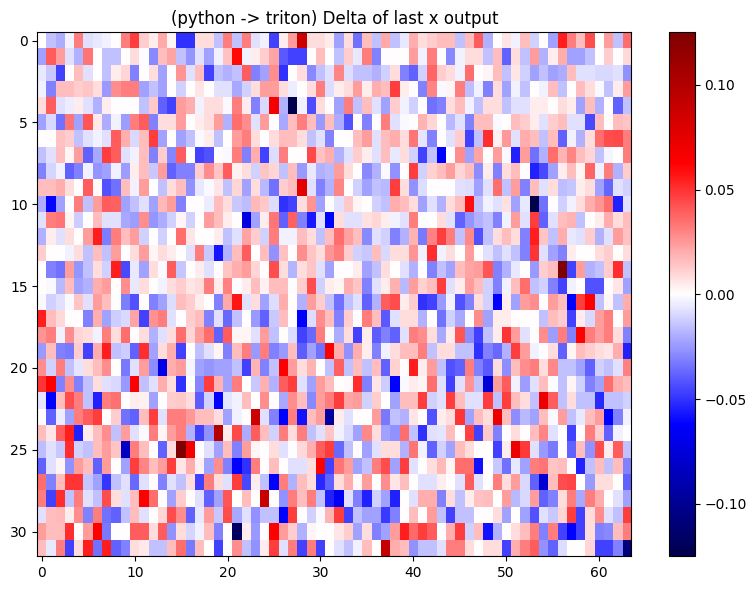

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_tr_x, cmap='seismic', aspect='auto')
im.set_clim(-abs_max_delta_tr_x, abs_max_delta_tr_x)
ax.set_title("(python -> triton) Delta of last x output")
fig.colorbar(im)
fig.tight_layout()
plt.show()

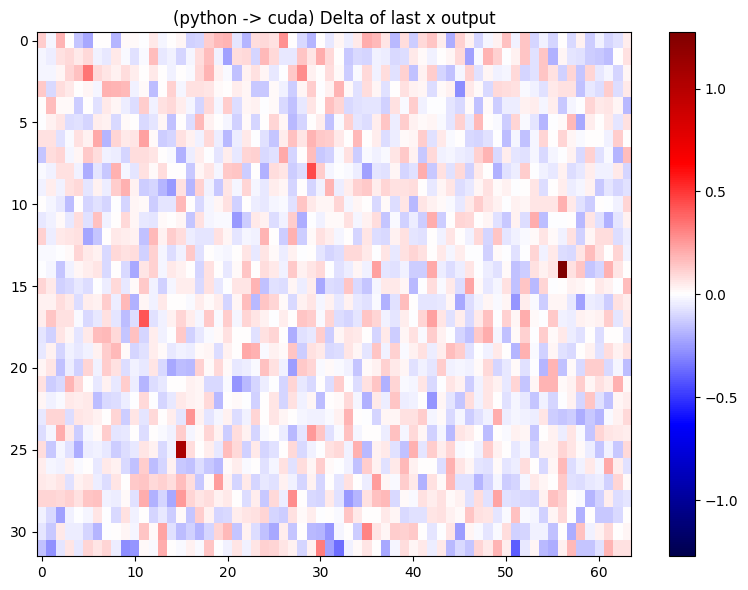

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_cu_x, cmap='seismic', aspect='auto')
im.set_clim(-abs_max_delta_cu_x, abs_max_delta_cu_x)
ax.set_title("(python -> cuda) Delta of last x output")
fig.colorbar(im)
fig.tight_layout()
plt.show()

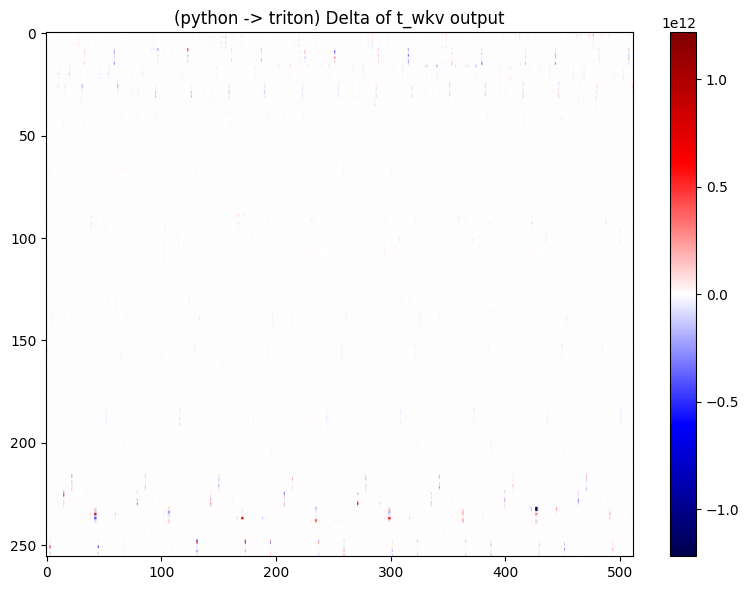

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_tr_t_wkv, cmap='seismic', aspect='auto')
im.set_clim(-abs_max_delta_tr_t_wkv, abs_max_delta_tr_t_wkv)
ax.set_title("(python -> triton) Delta of t_wkv output")
fig.colorbar(im)
fig.tight_layout()
plt.show()

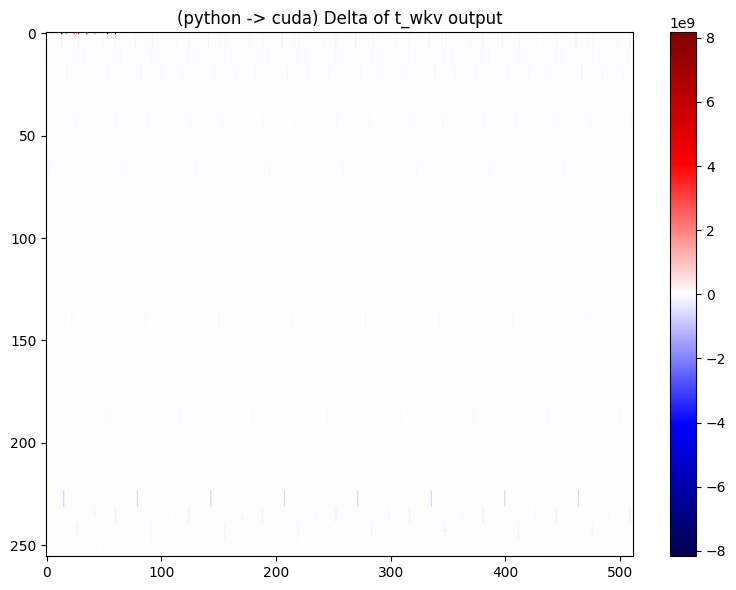

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_cu_t_wkv, cmap='seismic', aspect='auto')
im.set_clim(-abs_max_delta_cu_t_wkv, abs_max_delta_cu_t_wkv)
ax.set_title("(python -> cuda) Delta of t_wkv output")
fig.colorbar(im)
fig.tight_layout()
plt.show()

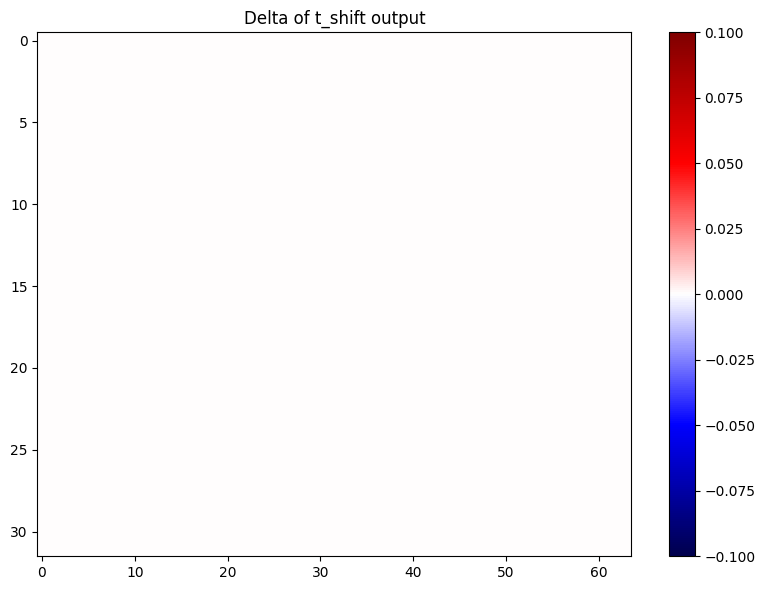

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_tr_t_shift, cmap='seismic', aspect='auto')
im.set_clim(-abs_max_delta_tr_t_shift, abs_max_delta_tr_t_shift)
ax.set_title("Delta of t_shift output")
fig.colorbar(im)
fig.tight_layout()
plt.show()

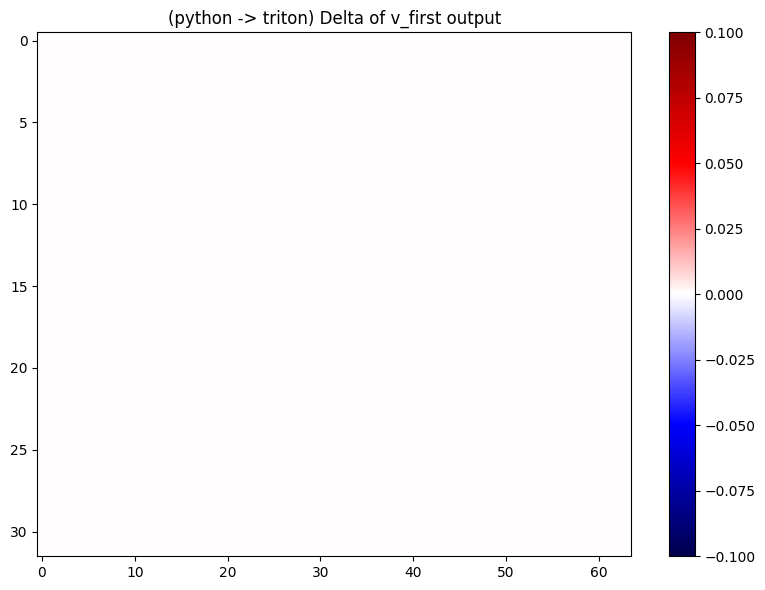

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_tr_v_first, cmap='seismic', aspect='auto')
im.set_clim(-abs_max_delta_tr_v_first, abs_max_delta_tr_v_first)
ax.set_title("(python -> triton) Delta of v_first output")
fig.colorbar(im)
fig.tight_layout()
plt.show()

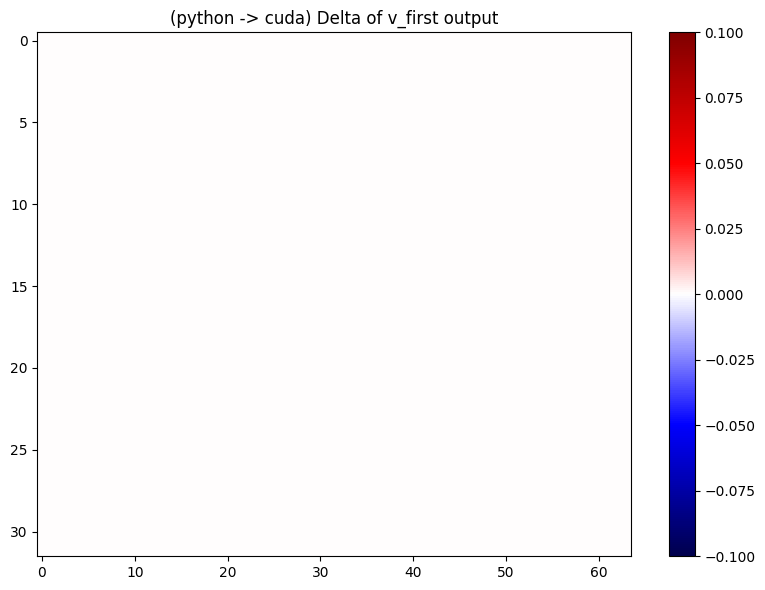

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_cu_v_first, cmap='seismic', aspect='auto')
im.set_clim(-abs_max_delta_cu_v_first, abs_max_delta_cu_v_first)
ax.set_title("(python -> cuda) Delta of v_first output")
fig.colorbar(im)
fig.tight_layout()
plt.show()

---
## RWKV Block Python / Reference Compare

In [15]:
# # Reference RWKV TMix as per
# # https://github.com/BlinkDL/ChatRWKV/blob/9284fa14d64146ee8817d134435102df9989c735/rwkv_pip_package/src/rwkv/model.py#L354C5-L378C48
# def RWKV_x070_TMix_one(layer_id: int, H:int, N:int, x, x_prev, v_first, state, x_r, x_w, x_k, x_v, x_a, x_g, w0, w1, w2, a0, a1, a2, v0, v1, v2, g1, g2, k_k, k_a, r_k, R_, K_, V_, O_, ln_w, ln_b):
#     xx = x_prev - x
#     xr, xw, xk, xv, xa, xg = x+xx*x_r, x+xx*x_w, x+xx*x_k, x+xx*x_v, x+xx*x_a, x+xx*x_g

#     r = xr @ R_
#     w = torch.tanh(xw @ w1) @ w2
#     k = xk @ K_
#     v = xv @ V_
#     a = torch.sigmoid(a0 + (xa @ a1) @ a2)
#     g = torch.sigmoid(xg @ g1) @ g2

#     kk = torch.nn.functional.normalize((k * k_k).view(H,N), dim=-1, p=2.0).view(H*N)
#     k = k * (1 + (a-1) * k_a)
#     if layer_id == 0: v_first = v
#     else: v = v + (v_first - v) * torch.sigmoid(v0 + (xv @ v1) @ v2)
#     w = torch.exp(-0.606531 * torch.sigmoid((w0 + w).float())) # 0.606531 = exp(-0.5)

#     vk = v.view(H,N,1) @ k.view(H,1,N)
#     ab = (-kk).view(H,N,1) @ (kk*a).view(H,1,N)
#     state = state * w.view(H,1,N) + state @ ab.float() + vk.float()
#     xx = (state.to(dtype=x.dtype) @ r.view(H,N,1))

#     xx = torch.nn.functional.group_norm(xx.view(1,H*N), num_groups=H, weight=ln_w, bias=ln_b, eps = 64e-5).view(H*N)    
#     xx = xx + ((r * k * r_k).view(H,N).sum(dim=-1, keepdim=True) * v.view(H,N)).view(H*N)
#     return (xx * g) @ O_, x, state, v_first
#     # return xx, t_shift, wkv_state, v_first

# Reference RWKV TMix as per
# https://github.com/BlinkDL/ChatRWKV/blob/9284fa14d64146ee8817d134435102df9989c735/rwkv_pip_package/src/rwkv/model.py#L407C9-L434C58
def RWKV_x070_TMix_seq(layer_id: int, H:int, N:int, x, x_prev, v_first, state, x_r, x_w, x_k, x_v, x_a, x_g, w0, w1, w2, a0, a1, a2, v0, v1, v2, g1, g2, k_k, k_a, r_k, R_, K_, V_, O_, ln_w, ln_b):
    T = x.shape[0]
    xx = torch.cat((x_prev.unsqueeze(0), x[:-1,:])) - x
    xr, xw, xk, xv, xa, xg = x+xx*x_r, x+xx*x_w, x+xx*x_k, x+xx*x_v, x+xx*x_a, x+xx*x_g

    r = xr @ R_
    w = torch.tanh(xw @ w1) @ w2
    k = xk @ K_
    v = xv @ V_
    a = torch.sigmoid(a0 + (xa @ a1) @ a2)
    g = torch.sigmoid(xg @ g1) @ g2

    kk = torch.nn.functional.normalize((k * k_k).view(T,H,N), dim=-1, p=2.0).view(T,H*N)
    k = k * (1 + (a-1) * k_a)
    if layer_id == 0: v_first = v
    else: v = v + (v_first - v) * torch.sigmoid(v0 + (xv @ v1) @ v2)

    w = torch.exp(-0.606531 * torch.sigmoid((w0 + w).float())) # 0.606531 = exp(-0.5)
    for t in range(T):
        r_, w_, k_, v_, kk_, a_ = r[t], w[t], k[t], v[t], kk[t], a[t]
        vk = v_.view(H,N,1) @ k_.view(H,1,N)
        ab = (-kk_).view(H,N,1) @ (kk_*a_).view(H,1,N)
        state = state * w_.view(H,1,N) + state @ ab.float() + vk.float()
        xx[t] = (state.to(dtype=x.dtype) @ r_.view(H,N,1)).view(H*N)

    xx = torch.nn.functional.group_norm(xx.view(T,H*N), num_groups=H, weight=ln_w, bias=ln_b, eps = 64e-5).view(T,H*N)
    xx = xx + ((r * k * r_k).view(T,H,N).sum(dim=-1, keepdim=True) * v.view(T,H,N)).view(T,H*N)
    return (xx * g) @ O_, x[-1,:], state, v_first

# NOTE: We use tmix_pytorch, to get the weights
def ref_tmix_forward(in_x, in_t_shift, in_t_wkv, in_v_first):
    configMap = tmix_pytorch.configMap

    layer_id = tmix_pytorch.layer_id
    n_dim_att = configMap.get_n_dim_att()
    head_size = configMap.head_size
    n_head = n_dim_att // head_size

    ############################
    #
    # IMPORTANT NOTE: For RWKV reference library, certain key operations are precomputed
    # See from here: https://github.com/BlinkDL/ChatRWKV/blob/9284fa14d64146ee8817d134435102df9989c735/rwkv_pip_package/src/rwkv/model.py#L254
    #
    # - Transposing the key, value, receptance, output, and head values
    #   ```
    #   if 'key.weight' in k or 'value.weight' in k or 'receptance.weight' in k or 'output.weight' in k or 'head.weight' in k:
    #       z[k] = z[k].t()
    #   ```
    # - Pre-Squeezing all weighted values
    #   ```
    #   z[k] = z[k].squeeze().to(dtype=DTYPE)
    #   ```
    # - Flatten the r_k value
    #   ```
    #   if k.endswith('att.r_k'): z[k] = z[k].flatten()
    #   ```
    # - Pre-Applying the block.0 ln0 to the embedding weights 
    #   (not applicable to the current test)
    #   ```
    #   z['emb.weight'] = F.layer_norm(z['emb.weight'], (args.n_embd,), weight=z['blocks.0.ln0.weight'], bias=z['blocks.0.ln0.bias'])
    #   ```
    #
    ############################

    # xx, state[i*3+0], state[i*3+1], v_first = RWKV_x070_TMix_one(i, self.n_head, self.head_size, xx, state[i*3+0], v_first, state[i*3+1],
    #     z[att+'x_r'], z[att+'x_w'], z[att+'x_k'], z[att+'x_v'], z[att+'x_a'], z[att+'x_g'],
    #     z[att+'w0'], z[att+'w1'], z[att+'w2'], z[att+'a0'], z[att+'a1'], z[att+'a2'], z[att+'v0'], z[att+'v1'], z[att+'v2'],
    #     z[att+'g1'], z[att+'g2'], z[att+'k_k'], z[att+'k_a'], z[att+'r_k'],
    #     z[att+'receptance.weight'], z[att+'key.weight'], z[att+'value.weight'], z[att+'output.weight'],
    #     z[att+'ln_x.weight'], z[att+'ln_x.bias'])

    assert layer_id == 0, "Only layer_id 0 is supported for now, modify code below to inlcude v0,v1,v2 for other layers"

    out_x, out_t_shift, out_t_wkv, out_v_first = RWKV_x070_TMix_seq(
        layer_id, n_head, head_size, 
        in_x, in_t_shift, in_v_first, in_t_wkv.float(),
        tmix_pytorch.x_r.squeeze(), tmix_pytorch.x_w.squeeze(), tmix_pytorch.x_k.squeeze(), tmix_pytorch.x_v.squeeze(), tmix_pytorch.x_a.squeeze(), tmix_pytorch.x_g.squeeze(),
        tmix_pytorch.w0.squeeze(), tmix_pytorch.w1.squeeze(), tmix_pytorch.w2.squeeze(), tmix_pytorch.a0.squeeze(), tmix_pytorch.a1.squeeze(), tmix_pytorch.a2.squeeze(), 
        None, None, None, # tmix_pytorch.v0.squeeze(), tmix_pytorch.v1.squeeze(), tmix_pytorch.v2.squeeze(),
        tmix_pytorch.g1.squeeze(), tmix_pytorch.g2.squeeze(), tmix_pytorch.k_k.squeeze(), tmix_pytorch.k_a.squeeze(), tmix_pytorch.r_k.squeeze().flatten(),
        tmix_pytorch.receptance.weight.t().squeeze(), tmix_pytorch.key.weight.t().squeeze(), tmix_pytorch.value.weight.t().squeeze(), tmix_pytorch.output.weight.t().squeeze(),
        tmix_pytorch.ln_x.weight.squeeze(), tmix_pytorch.ln_x.bias.squeeze()
    )
    return out_x, out_t_shift, out_t_wkv.to(in_t_wkv.dtype), out_v_first

with torch.inference_mode():
    # Get output with python
    ref_out_x, ref_t_shift, ref_t_wkv, ref_v_first = ref_tmix_forward(
        torch.ones(IN_TOKENS_LEN, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE),
        torch.ones(n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE), 
        torch.ones(n_dim // 64, 64, 64, device=RUN_DEVICE, dtype=torch.float), 
        torch.ones(IN_TOKENS_LEN, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE)
    )

    delta_ref_py_out_x = (ref_out_x - py_out_x[0]).view(n_dim // 64, -1).float().cpu().numpy()
    delta_ref_py_t_shift = (ref_t_shift - py_t_shift).view(n_dim // 64, -1).float().cpu().numpy()
    delta_ref_py_t_wkv = (ref_t_wkv - py_t_wkv).view(n_dim // 64 * 8, -1).float().cpu().numpy()
    delta_ref_py_v_first = (ref_v_first - py_v_first[0]).view(n_dim // 64, -1).float().cpu().numpy()

    # Compute the max delta
    abs_max_delta_ref_py_out_x = max(delta_ref_py_out_x.min().item(), delta_ref_py_out_x.max().item())
    abs_max_delta_ref_py_t_shift = max(delta_ref_py_t_shift.min().item(), delta_ref_py_t_shift.max().item())
    abs_max_delta_ref_py_t_wkv = max(delta_ref_py_t_wkv.min().item(), delta_ref_py_t_wkv.max().item())
    abs_max_delta_ref_py_v_first = max(delta_ref_py_v_first.min().item(), delta_ref_py_v_first.max().item())

    # Compute and print the max/min delta
    print("Max delta (ref -> pytorch) for x       (shape:", delta_ref_py_out_x.shape," max:", delta_ref_py_out_x.max().item(),", min:", delta_ref_py_out_x.min().item(),")")
    print("Max delta (ref -> pytorch) for t_shift (shape:", delta_ref_py_t_shift.shape," max:", delta_ref_py_t_shift.max().item(),", min:", delta_ref_py_t_shift.min().item(),")")
    print("Max delta (ref -> pytorch) for t_wkv   (shape:", delta_ref_py_t_wkv.shape," max:", delta_ref_py_t_wkv.max().item(),", min:", delta_ref_py_t_wkv.min().item(),")")
    print("Max delta (ref -> pytorch) for v_first (shape:", delta_ref_py_v_first.shape," max:", delta_ref_py_v_first.max().item(),", min:", delta_ref_py_v_first.min().item(),")")


Max delta (ref -> pytorch) for x       (shape: (32, 576000)  max: 0.0 , min: 0.0 )
Max delta (ref -> pytorch) for t_shift (shape: (32, 64)  max: 0.0 , min: 0.0 )
Max delta (ref -> pytorch) for t_wkv   (shape: (256, 512)  max: 0.0 , min: 0.0 )
Max delta (ref -> pytorch) for v_first (shape: (32, 576000)  max: 0.0 , min: 0.0 )
